In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
def load_audio_files_with_lengths(directory):
    audio_data = []
    lengths = []
    file_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".flac"):
            file_path = os.path.join(directory, filename)
            audio, sr = librosa.load(file_path, sr=None)
            audio_data.append(audio)
            lengths.append(len(audio))
            file_paths.append(file_path)
    return audio_data, lengths, file_paths

In [3]:
male_dir = r"E:\Audio Dataset\male"
female_dir = r"E:\Audio Dataset\female"

male_audio, male_lengths, male_paths = load_audio_files_with_lengths(male_dir)
female_audio, female_lengths, female_paths = load_audio_files_with_lengths(female_dir)

In [4]:
total_male_audios = len(male_audio)
total_female_audios = len(female_audio)
print("total_male_audios",total_male_audios)
print("total_female_audios",total_female_audios)

total_male_audios 1128
total_female_audios 1218


In [5]:
all_lengths = male_lengths + female_lengths
all_paths = male_paths + female_paths

min_index = np.argmin(all_lengths)

In [6]:
shortest_file_path = all_paths[min_index]
shortest_length = all_lengths[min_index]
shortest_length_sec = shortest_length / 22050  

print(f"Path of the file with the shortest length: {shortest_file_path}")
print(f"Length of the file in seconds: {shortest_length_sec:.2f} seconds")

Path of the file with the shortest length: E:\Audio Dataset\male\2428-83699-0001.flac
Length of the file in seconds: 1.50 seconds


In [7]:
def trim_audio(audio_data, length):
    return [audio[:length] for audio in audio_data]

male_audio_trimmed = trim_audio(male_audio, shortest_length)
female_audio_trimmed = trim_audio(female_audio, shortest_length)

In [8]:
def extract_features(audio_data):
    features = []
    for audio in audio_data:
        mfcc = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
        features.append(mfcc)
    return features

In [9]:
male_features = extract_features(male_audio_trimmed)
female_features = extract_features(female_audio_trimmed)

In [10]:
male_labels = ['male'] * len(male_features)
female_labels = ['female'] * len(female_features)
features = male_features + female_features
labels = male_labels + female_labels

In [11]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [12]:
X = np.array(features)
X = np.expand_dims(X, -1)  
y = np.array(labels)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Define and train LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
features_output = Dense(64, activation='relu')(x) 
final_output = Dense(1, activation='sigmoid')(features_output)

model = Model(inputs, final_output)  

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/1000


118/118 [==============================] - 7s 21ms/step - loss: 0.6928 - accuracy: 0.5299 - val_loss: 0.6836 - val_accuracy: 0.5468
Epoch 2/1000
118/118 [==============================] - 2s 13ms/step - loss: 0.6499 - accuracy: 0.6247 - val_loss: 0.6451 - val_accuracy: 0.6426
Epoch 3/1000
118/118 [==============================] - 2s 13ms/step - loss: 0.5906 - accuracy: 0.6914 - val_loss: 0.6358 - val_accuracy: 0.6447
Epoch 4/1000
118/118 [==============================] - 2s 13ms/step - loss: 0.5276 - accuracy: 0.7521 - val_loss: 0.5930 - val_accuracy: 0.7043
Epoch 5/1000
118/118 [==============================] - 2s 13ms/step - loss: 0.4635 - accuracy: 0.7932 - val_loss: 0.6137 - val_accuracy: 0.7149
Epoch 6/1000
118/118 [==============================] - 2s 13ms/step - loss: 0.4012 - accuracy: 0.8118 - val_loss: 0.6367 - val_accuracy: 0.7170
Epoch 7/1000
118/118 [==============================] - 2s 13ms/step - loss: 0.3691 - accuracy: 0.8364 - val_loss: 0.6331 - val

Epoch 53/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0728 - accuracy: 0.9749 - val_loss: 1.0594 - val_accuracy: 0.7489
Epoch 54/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0778 - accuracy: 0.9712 - val_loss: 0.9717 - val_accuracy: 0.7532
Epoch 55/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0727 - accuracy: 0.9755 - val_loss: 1.0140 - val_accuracy: 0.7319
Epoch 56/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0869 - accuracy: 0.9717 - val_loss: 0.9617 - val_accuracy: 0.7426
Epoch 57/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0620 - accuracy: 0.9781 - val_loss: 1.0657 - val_accuracy: 0.7426
Epoch 58/1000
118/118 [==============================] - 3s 22ms/step - loss: 0.0788 - accuracy: 0.9739 - val_loss: 1.0013 - val_accuracy: 0.7574
Epoch 59/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0706 - accuracy: 0.9728 - val_loss: 1.1288 -

118/118 [==============================] - 2s 14ms/step - loss: 0.0561 - accuracy: 0.9829 - val_loss: 1.1220 - val_accuracy: 0.7702
Epoch 110/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0588 - accuracy: 0.9803 - val_loss: 1.0404 - val_accuracy: 0.7723
Epoch 111/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0598 - accuracy: 0.9813 - val_loss: 0.9335 - val_accuracy: 0.7894
Epoch 112/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0449 - accuracy: 0.9835 - val_loss: 1.0985 - val_accuracy: 0.7617
Epoch 113/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0562 - accuracy: 0.9813 - val_loss: 1.0880 - val_accuracy: 0.7723
Epoch 114/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0496 - accuracy: 0.9840 - val_loss: 1.0242 - val_accuracy: 0.7617
Epoch 115/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0423 - accuracy: 0.9877 - val_loss: 1.0951 - val_acc

Epoch 165/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0343 - accuracy: 0.9851 - val_loss: 1.0366 - val_accuracy: 0.7745
Epoch 166/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0426 - accuracy: 0.9840 - val_loss: 1.0947 - val_accuracy: 0.7809
Epoch 167/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0414 - accuracy: 0.9851 - val_loss: 1.1432 - val_accuracy: 0.7851
Epoch 168/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0466 - accuracy: 0.9888 - val_loss: 1.0442 - val_accuracy: 0.7894
Epoch 169/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.9780 - val_accuracy: 0.7851
Epoch 170/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0550 - accuracy: 0.9840 - val_loss: 0.9395 - val_accuracy: 0.7830
Epoch 171/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0472 - accuracy: 0.9829 - val_loss: 0

Epoch 221/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0360 - accuracy: 0.9872 - val_loss: 0.9353 - val_accuracy: 0.7915
Epoch 222/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0314 - accuracy: 0.9877 - val_loss: 0.9643 - val_accuracy: 0.7915
Epoch 223/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0336 - accuracy: 0.9856 - val_loss: 1.0336 - val_accuracy: 0.7830
Epoch 224/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0283 - accuracy: 0.9904 - val_loss: 1.0610 - val_accuracy: 0.7872
Epoch 225/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0348 - accuracy: 0.9904 - val_loss: 1.0024 - val_accuracy: 0.7766
Epoch 226/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0374 - accuracy: 0.9888 - val_loss: 1.0433 - val_accuracy: 0.7872
Epoch 227/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0413 - accuracy: 0.9861 - val_loss: 1

Epoch 277/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0340 - accuracy: 0.9877 - val_loss: 1.0568 - val_accuracy: 0.8064
Epoch 278/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0337 - accuracy: 0.9883 - val_loss: 1.0490 - val_accuracy: 0.8000
Epoch 279/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0294 - accuracy: 0.9872 - val_loss: 0.9946 - val_accuracy: 0.8064
Epoch 280/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0300 - accuracy: 0.9893 - val_loss: 1.0789 - val_accuracy: 0.7936
Epoch 281/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0313 - accuracy: 0.9883 - val_loss: 1.0370 - val_accuracy: 0.8064
Epoch 282/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0216 - accuracy: 0.9920 - val_loss: 1.1813 - val_accuracy: 0.7809
Epoch 283/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0211 - accuracy: 0.9904 - val_loss: 1

Epoch 333/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0353 - accuracy: 0.9872 - val_loss: 0.9048 - val_accuracy: 0.8043
Epoch 334/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 1.0222 - val_accuracy: 0.8043
Epoch 335/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0325 - accuracy: 0.9899 - val_loss: 1.0162 - val_accuracy: 0.7851
Epoch 336/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0414 - accuracy: 0.9861 - val_loss: 0.9745 - val_accuracy: 0.7915
Epoch 337/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0204 - accuracy: 0.9920 - val_loss: 1.0076 - val_accuracy: 0.7915
Epoch 338/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0347 - accuracy: 0.9872 - val_loss: 0.9957 - val_accuracy: 0.8043
Epoch 339/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0258 - accuracy: 0.9899 - val_loss: 1

Epoch 389/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 1.1605 - val_accuracy: 0.7915
Epoch 390/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0365 - accuracy: 0.9872 - val_loss: 1.1669 - val_accuracy: 0.7872
Epoch 391/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0225 - accuracy: 0.9925 - val_loss: 1.1218 - val_accuracy: 0.7979
Epoch 392/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 1.1168 - val_accuracy: 0.8021
Epoch 393/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0272 - accuracy: 0.9904 - val_loss: 1.0918 - val_accuracy: 0.8106
Epoch 394/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0213 - accuracy: 0.9925 - val_loss: 1.0627 - val_accuracy: 0.8149
Epoch 395/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0259 - accuracy: 0.9888 - val_loss: 1

Epoch 445/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0323 - accuracy: 0.9909 - val_loss: 1.1737 - val_accuracy: 0.7957
Epoch 446/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0295 - accuracy: 0.9904 - val_loss: 1.1142 - val_accuracy: 0.7915
Epoch 447/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0192 - accuracy: 0.9925 - val_loss: 1.1236 - val_accuracy: 0.8021
Epoch 448/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0319 - accuracy: 0.9915 - val_loss: 1.0403 - val_accuracy: 0.8213
Epoch 449/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 1.0252 - val_accuracy: 0.8128
Epoch 450/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0293 - accuracy: 0.9899 - val_loss: 1.0990 - val_accuracy: 0.8021
Epoch 451/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0330 - accuracy: 0.9877 - val_loss: 1

Epoch 501/1000
118/118 [==============================] - 2s 15ms/step - loss: 0.0159 - accuracy: 0.9931 - val_loss: 1.2582 - val_accuracy: 0.8043
Epoch 502/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0213 - accuracy: 0.9920 - val_loss: 1.2875 - val_accuracy: 0.7957
Epoch 503/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0287 - accuracy: 0.9899 - val_loss: 1.2876 - val_accuracy: 0.7872
Epoch 504/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0393 - accuracy: 0.9867 - val_loss: 1.0860 - val_accuracy: 0.8106
Epoch 505/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0255 - accuracy: 0.9904 - val_loss: 1.1401 - val_accuracy: 0.8064
Epoch 506/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 1.1479 - val_accuracy: 0.8064
Epoch 507/1000
118/118 [==============================] - 2s 16ms/step - loss: 0.0321 - accuracy: 0.9904 - val_loss: 1

Epoch 557/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0376 - accuracy: 0.9904 - val_loss: 0.9766 - val_accuracy: 0.8170
Epoch 558/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0316 - accuracy: 0.9888 - val_loss: 1.0242 - val_accuracy: 0.8191
Epoch 559/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0205 - accuracy: 0.9952 - val_loss: 1.1264 - val_accuracy: 0.8043
Epoch 560/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0133 - accuracy: 0.9952 - val_loss: 1.1201 - val_accuracy: 0.8191
Epoch 561/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0270 - accuracy: 0.9904 - val_loss: 1.0552 - val_accuracy: 0.8234
Epoch 562/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0153 - accuracy: 0.9947 - val_loss: 1.0946 - val_accuracy: 0.8191
Epoch 563/1000
118/118 [==============================] - 2s 17ms/step - loss: 0.0226 - accuracy: 0.9920 - val_loss: 1

Epoch 613/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0163 - accuracy: 0.9941 - val_loss: 1.0962 - val_accuracy: 0.8277
Epoch 614/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0373 - accuracy: 0.9899 - val_loss: 0.9129 - val_accuracy: 0.8383
Epoch 615/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.9543 - val_accuracy: 0.8362
Epoch 616/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0195 - accuracy: 0.9947 - val_loss: 1.0405 - val_accuracy: 0.8255
Epoch 617/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 1.0136 - val_accuracy: 0.8319
Epoch 618/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.9254 - val_accuracy: 0.8277
Epoch 619/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0182 - accuracy: 0.9947 - val_loss: 0

Epoch 669/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0166 - accuracy: 0.9947 - val_loss: 1.0746 - val_accuracy: 0.8149
Epoch 670/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 1.0396 - val_accuracy: 0.8191
Epoch 671/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 0.9784 - val_accuracy: 0.8319
Epoch 672/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0283 - accuracy: 0.9893 - val_loss: 0.8929 - val_accuracy: 0.8319
Epoch 673/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0233 - accuracy: 0.9904 - val_loss: 0.9208 - val_accuracy: 0.8255
Epoch 674/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0226 - accuracy: 0.9925 - val_loss: 1.0015 - val_accuracy: 0.8234
Epoch 675/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0194 - accuracy: 0.9925 - val_loss: 1

Epoch 725/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0098 - accuracy: 0.9979 - val_loss: 1.1432 - val_accuracy: 0.8298
Epoch 726/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 1.1317 - val_accuracy: 0.8298
Epoch 727/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0140 - accuracy: 0.9947 - val_loss: 1.1401 - val_accuracy: 0.8298
Epoch 728/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0158 - accuracy: 0.9963 - val_loss: 1.0939 - val_accuracy: 0.8298
Epoch 729/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0176 - accuracy: 0.9952 - val_loss: 1.0288 - val_accuracy: 0.8426
Epoch 730/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0117 - accuracy: 0.9968 - val_loss: 1.1719 - val_accuracy: 0.8340
Epoch 731/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 1

Epoch 781/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0150 - accuracy: 0.9936 - val_loss: 0.9396 - val_accuracy: 0.8532
Epoch 782/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.9291 - val_accuracy: 0.8447
Epoch 783/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0287 - accuracy: 0.9931 - val_loss: 0.8642 - val_accuracy: 0.8426
Epoch 784/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0214 - accuracy: 0.9925 - val_loss: 0.8442 - val_accuracy: 0.8532
Epoch 785/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0165 - accuracy: 0.9936 - val_loss: 0.8900 - val_accuracy: 0.8532
Epoch 786/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0175 - accuracy: 0.9968 - val_loss: 0.9002 - val_accuracy: 0.8574
Epoch 787/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0247 - accuracy: 0.9936 - val_loss: 0

Epoch 837/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 1.1013 - val_accuracy: 0.8362
Epoch 838/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 1.0439 - val_accuracy: 0.8383
Epoch 839/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 1.1128 - val_accuracy: 0.8319
Epoch 840/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0193 - accuracy: 0.9952 - val_loss: 1.0518 - val_accuracy: 0.8319
Epoch 841/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 1.1076 - val_accuracy: 0.8213
Epoch 842/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0192 - accuracy: 0.9931 - val_loss: 1.0578 - val_accuracy: 0.8298
Epoch 843/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0232 - accuracy: 0.9941 - val_loss: 1

Epoch 893/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.9448 - val_accuracy: 0.8298
Epoch 894/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.9747 - val_accuracy: 0.8234
Epoch 895/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0173 - accuracy: 0.9941 - val_loss: 0.9819 - val_accuracy: 0.8213
Epoch 896/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0110 - accuracy: 0.9957 - val_loss: 1.0137 - val_accuracy: 0.8298
Epoch 897/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0216 - accuracy: 0.9925 - val_loss: 1.0376 - val_accuracy: 0.8213
Epoch 898/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0242 - accuracy: 0.9925 - val_loss: 1.0715 - val_accuracy: 0.8149
Epoch 899/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0147 - accuracy: 0.9947 - val_loss: 1

Epoch 949/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0204 - accuracy: 0.9915 - val_loss: 0.9702 - val_accuracy: 0.8340
Epoch 950/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 0.9804 - val_accuracy: 0.8426
Epoch 951/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 1.0307 - val_accuracy: 0.8383
Epoch 952/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0172 - accuracy: 0.9947 - val_loss: 1.0808 - val_accuracy: 0.8468
Epoch 953/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0125 - accuracy: 0.9957 - val_loss: 1.1058 - val_accuracy: 0.8383
Epoch 954/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0174 - accuracy: 0.9941 - val_loss: 1.0583 - val_accuracy: 0.8277
Epoch 955/1000
118/118 [==============================] - 2s 14ms/step - loss: 0.0162 - accuracy: 0.9947 - val_loss: 1

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

15/15 [==============================] - 0s 8ms/step - loss: 0.8535 - accuracy: 0.8553
Test Accuracy: 0.8553191423416138


In [17]:
feature_extractor = Model(inputs, features_output)
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

15/15 [==============================] - 0s 6ms/step


In [18]:
# SVM Classifier
classifier_svm = SVC(kernel='linear', probability=True)
classifier_svm.fit(X_train_features, y_train)
y_pred_svm = classifier_svm.predict(X_test_features)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
print(f"Classifier SVM Test Accuracy: {accuracy_svm}")
print(f"Classifier SVM Test F1 Score: {f1_svm}")


Classifier SVM Test Accuracy: 0.8446808510638298
Classifier SVM Test F1 Score: 0.8436830835117773


In [19]:
# Additional Classifier: Random Forest
classifier_rf = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_rf.fit(X_train_features, y_train)
y_pred_rf = classifier_rf.predict(X_test_features)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Classifier RF Test Accuracy: {accuracy_rf}")
print(f"Classifier RF Test F1 Score: {f1_rf}")

Classifier RF Test Accuracy: 0.8446808510638298
Classifier RF Test F1 Score: 0.840958605664488


In [20]:
# Visualization of feature vectors
male_vectors = X_train_features[y_train == 0]
female_vectors = X_train_features[y_train == 1]

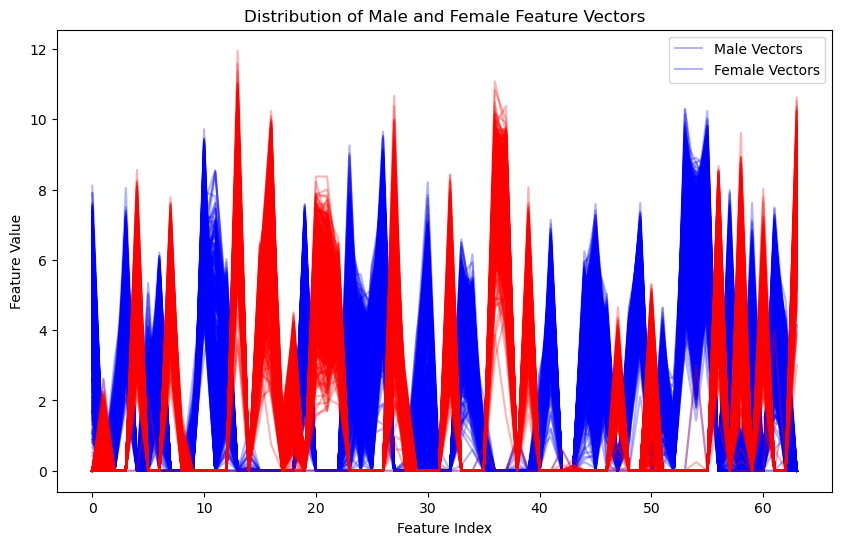

In [21]:
plt.figure(figsize=(10, 6))

# Plot male feature vectors
for i, vector in enumerate(male_vectors):
    plt.plot(vector, color='blue', alpha=0.3)  # Blue for male vectors

# Plot female feature vectors
for i, vector in enumerate(female_vectors):
    plt.plot(vector, color='red', alpha=0.3)  # Red for female vectors

plt.title("Distribution of Male and Female Feature Vectors")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend(["Male Vectors", "Female Vectors"])
plt.show()

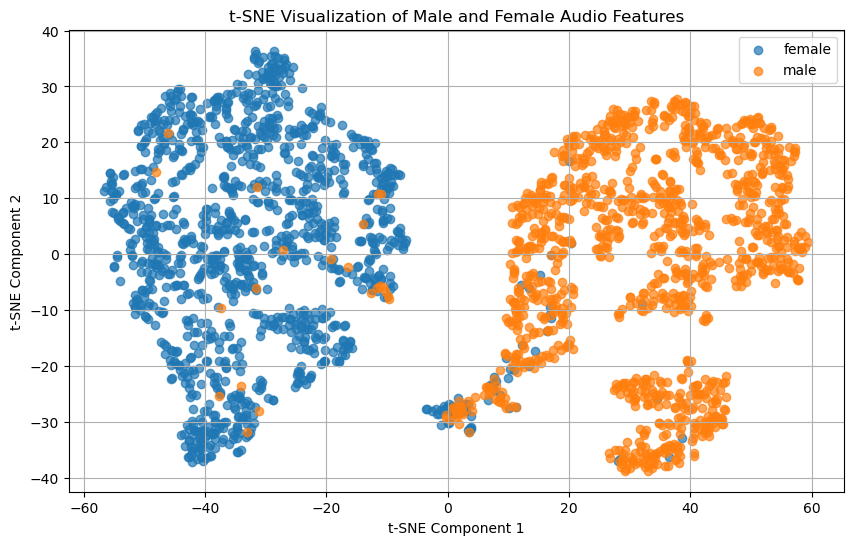

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

features_combined = np.concatenate((X_train_features, X_test_features), axis=0)
labels_combined = np.concatenate((y_train, y_test), axis=0)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features_combined)

plt.figure(figsize=(10, 6))
for label in np.unique(labels_combined):
    indices = np.where(labels_combined == label)
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=label_encoder.inverse_transform([label])[0], alpha=0.7)

plt.title('t-SNE Visualization of Male and Female Audio Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()